In [ ]:
import torch
from transformers import Owlv2Processor, Owlv2ForObjectDetection
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
from PIL import Image
from io import BytesIO
import sys
from config import topview_vec, sideview_vec
# sys.path.append("../")
from magpie_control import realsense_wrapper as real
from magpie_control.ur5 import UR5_Interface as robot
from magpie_perception.label_owlv2 import LabelOWLv2
import numpy as np
import pyrealsense2 as rs
import random
import time
import json
import warnings
import os
import cv2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
myrs = real.RealSense()
myrs.initConnection()
myrobot = robot()
myrobot.start()
label_vit = LabelOWLv2(topk=1, score_threshold= 0.05, cpu_override=False)


Found Dynamixel Port:
/dev/ttyACM0

Succeeded to open the port
Succeeded to change the baudrate
Moving speed of dxl ID: 1 set to 100 
Moving speed of dxl ID: 2 set to 100 


In [3]:
myrobot.open_gripper()


Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 


In [ ]:
def get_frames(rsWrapper):
    pipe, config = rsWrapper.pipe, rsWrapper.config
    frames = pipe.wait_for_frames()
    #alignOperator = rs.align(rs.stream.color)
    #alignOperator.process(frames)
    depthFrame = frames.get_depth_frame()  # pyrealsense2.depth_frame
    colorFrame = frames.get_color_frame()
    return colorFrame, depthFrame
def get_pictures(rsWrapper):
    colorFrame, depthFrame = get_frames(rsWrapper)
    #print(f"{type(starting_img)=}")
    #print(f"{dir(starting_img)=}")
    color_image = np.asarray(colorFrame.get_data())
    #color_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
    depth_image = np.asarray(depthFrame.get_data())
    return color_image, depth_image

In [ ]:
def pose_vector_distance(goal_vec, actual_pose):
    """
    Check if two 6-degree pose vectors are equivalent within a specified tolerance.

    Parameters:
    - goal_vec: List of target pose [x, y, z, rx, ry, rz] in meters.
    - actual_pose: List of actual pose [x, y, z, rx, ry, rz] in meters.
    - tolerance_cm: Tolerance in centimeters (default is 0.01 meters).

    Returns:
    - True if the poses are equivalent within the tolerance, False otherwise.
    """


    # Calculate linear distance
    linear_distance = np.linalg.norm(np.array(goal_vec[:3]) - np.array(actual_pose[:3]))

    # Calculate angular differences (wrap around at 2*pi)
    angular_diffs = [
        np.arctan2(np.sin(goal_vec[i] - actual_pose[i]), np.cos(goal_vec[i] - actual_pose[i]))
        for i in range(3, 6)
    ]
    angular_distance = np.linalg.norm(angular_diffs)

    # Total distance check (considering both linear and angular)
    return linear_distance, angular_distance

def goto_vec(UR_interface, goal_vec, warning_tolorance=0.01, failure_tolerance=0.1):
    print(f"{goal_vec=}")
    goal_matrix = UR_interface.poseVectorToMatrix(goal_vec)
    UR_interface.moveL(goal_matrix, linSpeed=0.1, asynch=False)
    actual_pose = UR_interface.recv.getActualTCPPose()
    print(f"{actual_pose=}")
    linear_error, angular_error = pose_vector_distance(goal_vec, actual_pose)
    
    success = True
    if linear_error >= warning_tolorance:
        assert linear_error < failure_tolerance, f"Linear Error greater than failure tolerance {linear_error=} {goal_vec=} {actual_pose=}"
        warnings.warn(f"Linear Error greater than warning tolerance {linear_error=} {goal_vec=} {actual_pose=}")
        success = False
    if angular_error >= warning_tolorance:
        assert angular_error < failure_tolerance, f"Angular Error greater than failure tolerance {linear_error=} {goal_vec=} {actual_pose=}"
        warnings.warn(f"Angular Error greater than warning tolerance {angular_error=} {goal_vec=} {actual_pose=}")
        success = False
    return success


In [ ]:
from openai import OpenAI
import requests
import base64
import io
from config import API_KEY
from pydantic import BaseModel

client = OpenAI(
    api_key= API_KEY,
)
"""
class Step(BaseModel):
    expanation: str
    output: json

class StackReasioning(BaseModel):
    steps: list[Step]
    final_answer: json
"""
#Function that takes a list of blocks in order of the tower [red, green, blue] and produces a prompt to be given to the GPT4o in sideview
#https://platform.openai.com/docs/guides/structured-outputs/examples
def set_prompt(str_list_stack_order):
    input_str = (f"""You are a block stacking robot, your job is to take an order of colored blocks to build a tower and an image of the current state of blocks
                  Then you should output a json with entries for pick:color of 'block', place:color of "block", Done:0/1 when the tower is complete, and explanation:str
                 that explains how this pick and place will get us closer to the desired tower.
                 
                 Some example of these jsons would be
                 {{
                     "pick":"red block"
                     "place":"blue block"
                     "Done":0
                     "explanation": "The blue block is already in the correct position, and the correct position for the red block is on the blue block
                     our next action will place a block on the redblock"
                 }}

                 {{
                     "pick":"green block"
                     "place":"red block"
                     "Done":0
                    "explanation": "The red block is already in the correct position, and the correct position for the green block is on the red block
                     our next action will place a block on the green block"
                 }}

                 {{
                     "pick":"red block"
                     "place":"table"
                     "Done":0
                    "explanation": "The red block is on top of the blue block which is not the correct position, we must free the blue block by placing the red block on the table
                    our next action will use the free blue block"
                 }}

                 {{
                     "pick":"None"
                     "place":"None"
                     "Done":1
                    "explanation": "The image of the current state of the block tower shows that we have the blocks in the correct order"

                 }}
                
                 You should only out put one json for the next step to get to the desired tower given the photo.
                 Then you should explain how this instance of pick and place gets us closer to the desired tower.

                 Your current task is to give me the next instruction so the blocks are stacked from bottom to top in order {str_list_stack_order}
                 when the current state is in the image provided
                explain how this action of pick and place gets us closer to the desired tower in bottom to top order {str_list_stack_order}""")
    
    user_prompt = ""
    return input_str, user_prompt

#helper function that formats the image for GPT api
def ndarray_to_base64(ndarray):
    # Convert the ndarray to a PIL Image
    image = Image.fromarray(ndarray)
    
    # Create a BytesIO object to save the image
    buffered = io.BytesIO()
    image.save(buffered, format="JPEG")  # Specify the format you want
    # Get the byte data and encode to base64
    encoded_string = base64.b64encode(buffered.getvalue()).decode('utf-8')
    
    return encoded_string

#api calling function
def get_response(str_prompt, user_prompt, img_prompt):
    image = ndarray_to_base64(img_prompt)
    img_type = "image/jpeg"
    # Save the image to a file
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            { "role": "system", "content": [{"type": "text", "text": str_prompt},{"type": "image_url", "image_url": {"url": f"data:{img_type};base64,{image}"},},],},
            {"role": "user", "content": user_prompt}
        ],
    ) 
    dict_resp = response.to_dict()
    message = dict_resp['choices'][0]['message']["content"]
    first_bracket = message.index("{")
    second_bracket = message.index("}")
    # Extract the JSON string
    json_string = message[first_bracket:second_bracket + 1]

    # Parse the JSON string into a Python dictionary
    json_instruction = json.loads(json_string)

    #print(json_instruction)
    return response, json_instruction




In [6]:
output_str = set_prompt(["red", "blue", "green"])
print(output_str)

('You are a block stacking robot, your job is to take an order of blocks to build a tower and an image of the current state of blocks\n                  Then you should output a json with entries for pick:color of \'block\', place:color of "block", and Done:0/1 when the tower is complete.\n                  Guide the user through the solution step by step\n                 \n                 \n                 Then you should explain how this instance of pick and place gets us closer to the desired tower\n                  Give me the next instruction so the blocks are stacked from bottom to top in order [\'red\', \'blue\', \'green\']\n                when the current state is in the image provided\n                OUTPUT ONLY JSON for a single next instruction and make sure to use the word block in pick and place.\n                  Make sure pick and place are differnt blocks before answering\n                  explain how this action of pick and place gets us closer to the desired t

sideview_vec=[0.0360674358115564, -0.20624107287146376, 0.2646274319314355, 1.8434675848139614, 1.4569842711938066, -1.2315497051361715]
sideview_matrix=SE3(array([[ 0.026,  0.937, -0.35 ,  0.036],
           [ 0.501, -0.315, -0.806, -0.206],
           [-0.865, -0.154, -0.477,  0.265],
           [ 0.   ,  0.   ,  0.   ,  1.   ]]))


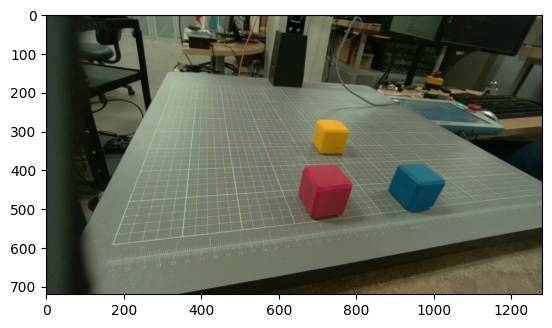

In [ ]:
#goto_sideview(myrobot, asynch = False)
goto_vec(myrobot, sideview_vec)
rgb_img, depth_img = get_pictures(myrs)
plt.figure()
plt.imshow(rgb_img)
plt.show()

#pick, place = pick_place_BB("green block", "blue block" , rgb_img, plot_bool=True)
#pick_block_str, place_block_str = prompt_planning_LLM(prompt, rgb_img)
#pick_block_str, place_block_str = "blue block", "red block"
#test = get_location_bbox(["green block","blue block"], pick, rgb_img)


In [8]:
##--string for GPT QUERY--##
output_str = set_prompt(["red", "blue", "green"])
print(output_str)

##--GPT QUERY--##

"""
gptresp, instruction = get_response(output_str, rgb_img)
print(gptresp)
print(instruction)
"""


('You are a block stacking robot, your job is to take an order of blocks to build a tower and an image of the current state of blocks\n                  Then you should output a json with entries for pick:color of \'block\', place:color of "block", and Done:0/1 when the tower is complete.\n                  Guide the user through the solution step by step\n                 \n                 \n                 Then you should explain how this instance of pick and place gets us closer to the desired tower\n                  Give me the next instruction so the blocks are stacked from bottom to top in order [\'red\', \'blue\', \'green\']\n                when the current state is in the image provided\n                OUTPUT ONLY JSON for a single next instruction and make sure to use the word block in pick and place.\n                  Make sure pick and place are differnt blocks before answering\n                  explain how this action of pick and place gets us closer to the desired t

'\ngptresp, instruction = get_response(output_str, rgb_img)\nprint(gptresp)\nprint(instruction)\n'

In [9]:
def parse_gpt(response):
    content = response[3]
    

In [ ]:
def get_depth_frame_intrinsics(rs_wrapper):
    rgb_frame, depth_frame = get_frames(rs_wrapper)
    intrinsics = depth_frame.profile.as_video_stream_profile().intrinsics
    return depth_frame, intrinsics

def get_topview_depth(point_list, UR_interface, rs_wrapper, n_samples = 50):
    goto_vec(UR_interface, topview_vec)
    depth_measurements = [[] for p in point_list]
    intrinsics = None
    for i in range(n_samples):
        depth_frame, intrinsics = get_depth_frame_intrinsics(rs_wrapper)
        for i, (x, y) in enumerate(point_list):
            depth_val = depth_frame.get_distance(x, y)  # in meters
            if depth_val > 0:
                depth_measurements[i].append(depth_val)

    
    depth_measurements = [np.array(point_measurements) for point_measurements in depth_measurements]
    final_depth_measurements = [0 for point in point_list]
    for i, measurements in enumerate(depth_measurements):
        std = np.std(measurements)
        mean = np.mean(measurements)
        in_std_mask = np.abs(measurements-mean) <= std
        depth_measurements = measurements[in_std_mask]
        #print(f"{depth_measurements=}")
        depth_val = sum(measurements)/len(measurements)
        #print(f"{depth_val=}")
        assert depth_val > 0, f"not able to get depth val after {n_samples} samples {depth_val=}"
        final_depth_measurements[i] = depth_val
    return final_depth_measurements

def deproject_top_view_point(K, pixel_x, pixel_y, depth):
    return rs.rs2_deproject_pixel_to_point(K, [pixel_x, pixel_y], depth)

In [ ]:
"""

pick_place_BB takes the color of the block that needs to be picked up and the color of the block 
to be placed on and gives the cords of where each are located as {xmin, ymin, xmax, ymax, strlabel}

"""
def topview_pick_place_BB(UR_Interface, rs_wrapper, pick_str, place_str, display= False):
    #print(place_str)
    #initlize local variables
    goto_vec(UR_Interface, topview_vec)
    rgb_img, depth_img = get_pictures(rs_wrapper)
    pick_cord_dict, place_cord_dict = {} , {}
    str_cords = ["xmin", "ymin", "xmax", "ymax"]
    queries = [pick_str, place_str]
    abbrevq = [pick_str, place_str]
    
    #pick bboxes and cords
    pick_bbox = label_vit.label(rgb_img, queries[0], abbrevq[0], plot=False, topk=True)
    pick_bbox_cords = pick_bbox[1][0].tolist()
    for pick , cord in zip(pick_bbox_cords, str_cords):
        pick_cord_dict[cord] = int(pick)
    pick_cord_dict["strlabel"] = pick_str
    pick_cord_dict["xCenter"] = int((pick_cord_dict['xmin'] + pick_cord_dict["xmax"])/2)
    pick_cord_dict["yCenter"] = int((pick_cord_dict['ymin'] + pick_cord_dict["ymax"])/2)
    
    

    #place bboxes and cords
    place_bbox = label_vit.label(rgb_img, queries[1], abbrevq[1], plot=False, topk=True)
    place_bbox_cords = place_bbox[1][0].tolist()
    for pick , cord in zip(place_bbox_cords, str_cords):
        place_cord_dict[cord] = int(pick)
    place_cord_dict["strlabel"] = place_str
    place_cord_dict["xCenter"] = int((place_cord_dict['xmin'] + place_cord_dict["xmax"])/2)
    place_cord_dict["yCenter"] = int((place_cord_dict['ymin'] + place_cord_dict["ymax"])/2)



    _, K = get_depth_frame_intrinsics(rs_wrapper)
    depth_querry_list = [
        (pick_cord_dict["xCenter"], pick_cord_dict["yCenter"]),
        (pick_cord_dict['xmin'], pick_cord_dict['ymin']),
        (pick_cord_dict['xmax'], pick_cord_dict['ymin']),
        (place_cord_dict["xCenter"], place_cord_dict["yCenter"]),
        (place_cord_dict['xmin'], place_cord_dict['ymin']),
        (place_cord_dict['xmax'], place_cord_dict['ymin'])
    ]
    pick_c_d, pick_ll_d, pick_lr_d, place_c_d, place_ll_d, place_lr_d = get_topview_depth(depth_querry_list, UR_Interface, rs_wrapper)

    pick_cord_dict["ImgFrameWorldCoord"] = deproject_top_view_point(K, pick_cord_dict["xCenter"], pick_cord_dict["yCenter"], pick_c_d)
    pick_LL_X, pick_LL_Y, pick_LL_Z = deproject_top_view_point(K, pick_cord_dict['xmin'], pick_cord_dict['ymin'], pick_ll_d)
    pick_LR_X, pick_LR_Y, pick_LR_Z = deproject_top_view_point(K, pick_cord_dict['xmax'], pick_cord_dict['ymin'], pick_lr_d)
    pick_sidelength =  (pick_LL_X-pick_LR_X)**2
    pick_sidelength += (pick_LL_Y-pick_LR_Y)**2
    pick_sidelength += (pick_LL_Z-pick_LR_Z)**2
    pick_sidelength = np.sqrt(pick_sidelength)
    pick_cord_dict["sidelength"] = pick_sidelength
    print(f"{pick_cord_dict=}")

    place_cord_dict["ImgFrameWorldCoord"] = deproject_top_view_point(K, place_cord_dict["xCenter"], place_cord_dict["yCenter"], place_c_d)
    place_LL_X, place_LL_Y, place_LL_Z = deproject_top_view_point(K, place_cord_dict['xmin'], place_cord_dict['ymin'], place_ll_d)
    place_LR_X, place_LR_Y, place_LR_Z = deproject_top_view_point(K, place_cord_dict['xmax'], place_cord_dict['ymin'], place_lr_d)
    place_sidelength =  (place_LL_X-place_LR_X)**2
    place_sidelength += (place_LL_Y-place_LR_Y)**2
    place_sidelength += (place_LL_Z-place_LR_Z)**2
    place_sidelength = np.sqrt(place_sidelength)
    place_cord_dict["sidelength"] = place_sidelength
    print(f"{place_cord_dict}=")
    

    
    if display:
        fig, ax = plt.subplots(1)
        ax.imshow(rgb_img)
        pick_rect = patches.Rectangle(
                                    (pick_cord_dict["xmin"], pick_cord_dict["ymin"]),
                                      pick_cord_dict["xmax"] - pick_cord_dict["xmin"],
                                      pick_cord_dict["ymax"] - pick_cord_dict["ymin"],
                                      linewidth=2, edgecolor='r', facecolor='none'
                                      )
        ax.add_patch(pick_rect)
        ax.text(pick_cord_dict["xmin"], pick_cord_dict["ymin"] - 10, f"pick: {pick_cord_dict['strlabel']}", color='r', fontsize=12, ha='left', va='bottom')
        

        place_rect = patches.Rectangle(
                                    (place_cord_dict["xmin"], place_cord_dict["ymin"]),
                                      place_cord_dict["xmax"] - place_cord_dict["xmin"],
                                      place_cord_dict["ymax"] - place_cord_dict["ymin"],
                                      linewidth=2, edgecolor='g', facecolor='none'
                                      )
        ax.add_patch(place_rect)
        ax.text(place_cord_dict["xmin"], place_cord_dict["ymin"] - 10, f"place {place_cord_dict['strlabel']}", color='g', fontsize=12, ha='left', va='bottom')
        ax.set_title("pick and place bb in rgb", fontsize=14)

        plt.show()


    #return dictionarys with {xmin, ymin, xmax, ymax, strlabel}
    #return (pick_bbox, pick_cord_dict) , (place_bbox, place_cord_dict)
    return pick_cord_dict, place_cord_dict

   



In [12]:
def pick(UR_interface, rsWrapper, bb, display=False):
    X, Y, Z = bb["ImgFrameWorldCoord"]
    print(f"Img Coordinates of Block: {X=}, {Y=}, {Z=}\n")
    new_X = topview_vec[0] - Y
    new_Y = topview_vec[1] - X


    
    print(f"{topview_vec=}")
    goal_vec = topview_vec.copy()
    goal_vec[0] = new_X
    goal_vec[1] = new_Y + 0.01
    goto_vec(UR_interface, goal_vec, tolorance=0.01)

    goal_z = topview_vec[2] - Z + 0.1
    goal_vec[2] = goal_z
    goto_vec(UR_interface, goal_vec, tolorance=0.01)

    UR_interface.close_gripper()
    time.sleep(2)

    goal_vec[2] = topview_vec[2]
    goto_vec(UR_interface, goal_vec, tolorance=0.01)


    if display:
        rgb_frame, depth_frame = get_frames(rsWrapper)
        depth_image = np.asarray(depth_frame.get_data())
        plt.imshow(depth_image)
        plt.gca().add_patch(plt.Rectangle(
            (bb['xmin'], bb['ymin']),
            bb['xmax'] - bb['xmin'],
            bb['ymax'] - bb['ymin'],
            edgecolor='red',
            facecolor='none',
            linewidth=2
        ))
        circle = plt.Circle((bb['xCenter'], bb['yCenter']), 5, edgecolor='blue', facecolor='none', linewidth=2)
        plt.gca().add_patch(circle)
        plt.text(bb['xmin'], bb['ymin'] - 10, bb['strlabel'],
                color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
        plt.axis('off')  # Hide axes
        plt.show()
    
    


#pick(myrobot, myrs, pick_bb, display = True)

In [ ]:
def place(UR_interface, rsWrapper, bb, display=False):
    X, Y, Z = bb["ImgFrameWorldCoord"]
    print(f"Img Coordinates of Block: {X=}, {Y=}, {Z=}\n")
    print(f"{topview_vec=}")


    new_X = topview_vec[0] - Y

    new_Y = topview_vec[1] - X  + 0.01
    goal_z = topview_vec[2] - Z + bb["sidelength"] + 0.0875

    goal_vec = topview_vec.copy()
    goal_vec[0] = new_X
    goal_vec[1] = new_Y
    goto_vec(UR_interface, goal_vec, tolorance=0.01)



    goal_vec[2] = goal_z
    goto_vec(UR_interface, goal_vec, tolorance=0.01)


    UR_interface.open_gripper()
    time.sleep(2)


    goal_vec[2] = topview_vec[2]
    goto_vec(UR_interface, goal_vec, tolorance=0.01)




    if display:
        rgb_frame, depth_frame = get_frames(rsWrapper)
        depth_image = np.asarray(depth_frame.get_data())
        plt.imshow(depth_img)
        plt.gca().add_patch(plt.Rectangle(
            (bb['xmin'], bb['ymin']),
            bb['xmax'] - bb['xmin'],
            bb['ymax'] - bb['ymin'],
            edgecolor='red',
            facecolor='none',
            linewidth=2
        ))
        circle = plt.Circle((bb['xCenter'], bb['yCenter']), 5, edgecolor='blue', facecolor='none', linewidth=2)
        plt.gca().add_patch(circle)
        plt.text(bb['xmin'], bb['ymin'] - 10, bb['strlabel'],
                color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
        plt.axis('off')  # Hide axes
        plt.show()
#place(myrobot, myrs, place_bb, display = True)

No LLM PLANNING

pick_cord_dict={'xmin': 356, 'ymin': 439, 'xmax': 447, 'ymax': 520, 'strlabel': 'blue block', 'xCenter': 401, 'yCenter': 479, 'ImgFrameWorldCoord': [-0.13437724113464355, 0.07057597488164902, 0.36588749289512634], 'sidelength': 0.05948993297747697}
{'xmin': 577, 'ymin': 351, 'xmax': 655, 'ymax': 425, 'strlabel': 'yellow block', 'xCenter': 616, 'yCenter': 388, 'ImgFrameWorldCoord': [-0.01033884659409523, 0.01784323714673519, 0.35967105627059937], 'sidelength': 0.04844281748309418}=


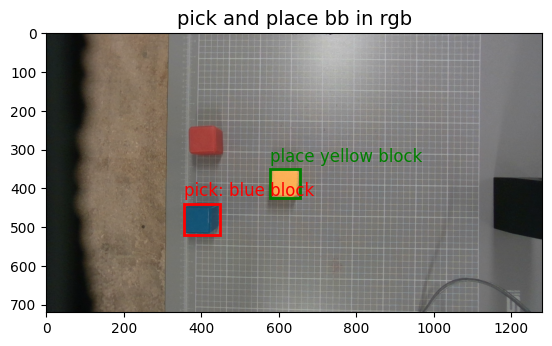

Img Coordinates of Block: X=-0.13437724113464355, Y=0.07057597488164902, Z=0.36588749289512634

topview_vec=[-0.16188220333609551, -0.6234229524443915, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]
goal_vec=[-0.23245817821774453, -0.47904571130974793, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]
actual_pose=[-0.23250702269306903, -0.47895462104561765, 0.5474309641086779, 3.894468390036172e-05, 3.141397111658913, 0.00047306801963115954]
goal_vec=[-0.23245817821774453, -0.47904571130974793, 0.28159640552658194, 1e-05, -3.141592653589793, -1e-05]
actual_pose=[-0.2324645358100699, -0.4790322642889292, 0.28165294844264865, 2.9502290684158252e-05, -3.14148897498031, 0.00022836862129644163]
Position of dxl ID: 1 set to 586 
Position of dxl ID: 2 set to 450 
goal_vec=[-0.23245817821774453, -0.47904571130974793, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]
actual_pose=[-0.2324555318533752, -0.4790428933750586, 0.5475007341563277, 9.364271487254336e-05, 3.14158620310

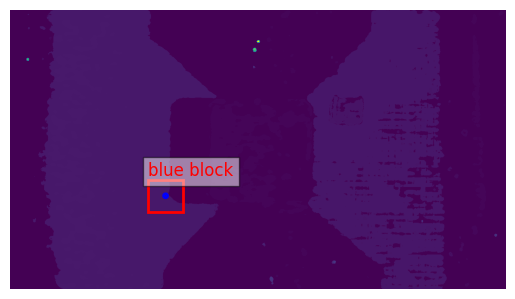

Img Coordinates of Block: X=-0.01033884659409523, Y=0.01784323714673519, Z=0.35967105627059937

topview_vec=[-0.16188220333609551, -0.6234229524443915, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]
goal_vec=[-0.1797254404828307, -0.6030841058502963, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]
actual_pose=[-0.17971921346732334, -0.6031939859021043, 0.5473938134913879, -8.471518547851989e-05, 3.141527795387551, 0.00019777597809140206]
goal_vec=[-0.1797254404828307, -0.6030841058502963, 0.3237556596342031, 1e-05, -3.141592653589793, -1e-05]
actual_pose=[-0.1797402087034529, -0.6030769753474029, 0.3237630360245262, 5.4624069283209335e-05, -3.1415074556229547, 0.00013639423572300773]
Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 
goal_vec=[-0.1797254404828307, -0.6030841058502963, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]
actual_pose=[-0.17968738402591727, -0.6030826909957232, 0.5475620391338383, 3.0111289380438188e-05, 3.141581066971514

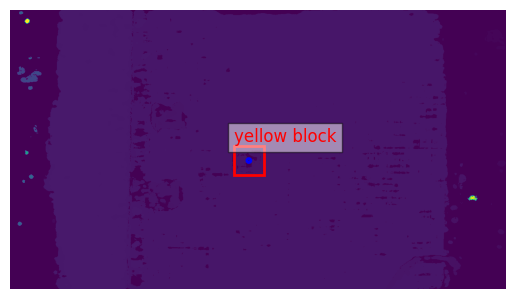

pick_cord_dict={'xmin': 372, 'ymin': 230, 'xmax': 461, 'ymax': 308, 'strlabel': 'red block', 'xCenter': 416, 'yCenter': 269, 'ImgFrameWorldCoord': [-0.12495888769626617, -0.050091806799173355, 0.36362650990486145], 'sidelength': 0.05575849383246097}
{'xmin': 568, 'ymin': 343, 'xmax': 655, 'ymax': 432, 'strlabel': 'blue block', 'xCenter': 611, 'yCenter': 387, 'ImgFrameWorldCoord': [-0.011695727705955505, 0.015342497266829014, 0.31939998269081116], 'sidelength': 0.05449590188537415}=


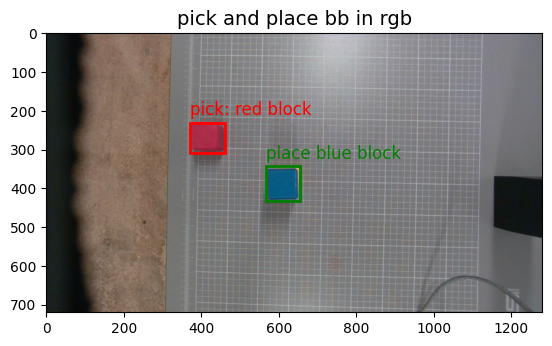

Img Coordinates of Block: X=-0.12495888769626617, Y=-0.050091806799173355, Z=0.36362650990486145

topview_vec=[-0.16188220333609551, -0.6234229524443915, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]
goal_vec=[-0.11179039653692216, -0.4884640647481253, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]
actual_pose=[-0.11170461843751603, -0.4883515995370848, 0.5475282143256712, 4.168481589095308e-05, -3.1415795637992616, -9.76549768611451e-05]
goal_vec=[-0.11179039653692216, -0.4884640647481253, 0.28385738851684683, 1e-05, -3.141592653589793, -1e-05]
actual_pose=[-0.11180166806663315, -0.4884382665941121, 0.28389490215050056, -0.00011708231223924534, -3.141542880041988, 0.00030251966516726595]
Position of dxl ID: 1 set to 586 
Position of dxl ID: 2 set to 450 
goal_vec=[-0.11179039653692216, -0.4884640647481253, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]
actual_pose=[-0.11179037491704666, -0.48842470696736184, 0.54758585858789, -8.932213511235517e-05, -3.1415130

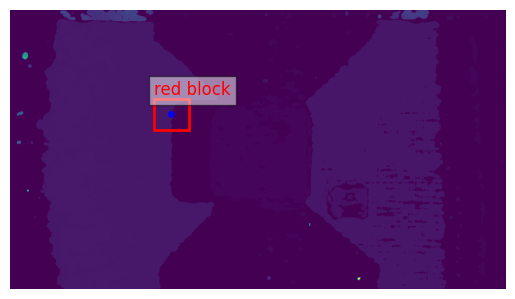

Img Coordinates of Block: X=-0.011695727705955505, Y=0.015342497266829014, Z=0.31939998269081116

topview_vec=[-0.16188220333609551, -0.6234229524443915, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]
goal_vec=[-0.17722470060292453, -0.601727224738436, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]
actual_pose=[-0.17715767155614143, -0.6018007146209923, 0.5474615907169846, 1.8180194695074728e-05, 3.1414783878535024, 4.7852595371135776e-05]
goal_vec=[-0.17722470060292453, -0.601727224738436, 0.3700798176162713, 1e-05, -3.141592653589793, -1e-05]
actual_pose=[-0.1772278833687736, -0.6016824063364599, 0.37012259531309544, 7.713331103773946e-05, -3.1415311333570552, 0.00017991480637992923]
Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 
goal_vec=[-0.17722470060292453, -0.601727224738436, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]
actual_pose=[-0.1772083939886387, -0.6016832804499054, 0.5475797148030419, 1.80940448956043e-05, -3.14157857077722

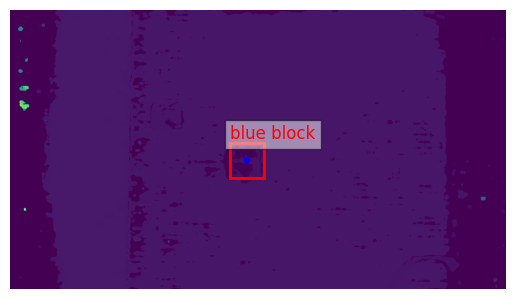

In [ ]:
#myrobot.stop()
#myrs.disconnect()
tower = ["red block", "blue block", "green block", "yellow block", "purple block", "orange block"]
#tower = ["yellow block", "blue block", "red block"]#, "green block"]
for i in range(0, len(tower)-1):
     pick_str = tower[i+1]
     place_str = tower[i]
     pick_bb, place_bb = topview_pick_place_BB(myrobot, myrs, pick_str, place_str, display=True)
     pick(myrobot, myrs, pick_bb, display = True)
     place(myrobot, myrs, place_bb, display = True)




YES LLM PLANNING

In [ ]:
#tower = ["red block", "blue block", "green block", "yellow block", "purple block"]
tower = ["red block", "blue block", "green block"]
n_attempts = 2*len(tower)
Done = 0
i = 0

while(not Done and i < n_attempts):
    i += 1
    goto_vec(myrobot, sideview_vec)
    rgb_img, depth_img = get_pictures(myrs)
    #this is broken right now will fix later
    sys_str , usr_str = set_prompt(tower)
    gptresp, instruction = get_response(sys_str, usr_str, rgb_img)
    print(f"{instruction=}")
    pick_str= instruction["pick"]
    place_str= instruction["place"]
    Done = int(instruction["Done"])
    pick_bb, place_bb = topview_pick_place_BB(myrobot, myrs, pick_str, place_str, plot_bool=True)
    pick(myrobot, myrs, pick_bb, display = True)
    place(myrobot, myrs, place_bb, display = True)


sideview_vec=[0.0360674358115564, -0.20624107287146376, 0.2646274319314355, 1.8434675848139614, 1.4569842711938066, -1.2315497051361715]
sideview_matrix=SE3(array([[ 0.026,  0.937, -0.35 ,  0.036],
           [ 0.501, -0.315, -0.806, -0.206],
           [-0.865, -0.154, -0.477,  0.265],
           [ 0.   ,  0.   ,  0.   ,  1.   ]]))
